# W13-02 - Reconocimiento de acciones

En la actividad veremos un ejemplo de cómo podemos utilizar redes neuronales convolucionales y redes neuronales recurrentes en la construcción de un modelo para el reconocimiento automático de acciones en video. Para el desarrollo de la actividad abordaremos:

1.   Descripción del problema
2.   Descripción de datos disponibles
3.   Análisis y diseño de propuesta de solución.   
> * Identificación de tipo de tarea(s) que se requiere realice el modelo (por ejemplo regresión, clasificación, localización, detección de objetos, etc.)
> * Características del conjunto de datos (X, Y)
> * Propuesta de arquitectura para el modelo base.
> * ¿Utilizaremos un modelo preentrenado como base de la solución? ¿cuál módelo preentrenado?
> * Tipos de tensores de entrada y salida del modelo.

4.   Implementación de prototipo de solución

5.   Entrenamiento, validación y pruebas

## **1. Descripción del problema**
#### **Construcción de un modelo para el reconocimiento de acciones en video**

El reconocimiento de acciones es un problema que consistente en etiquetar de forma automática videos (secuencias de imágenes) a partir de las acciones (beber, caminar, abrir la ventana, leer, etc.) que contenga cada video. Esta tarea resulta de gran relevancia en el análisis de repositorios de video para identificar segmentos de secuencias que contengan acciones de interés; por ejemplo: peleas, accidentes, robos, etc.

Para el desarrollo de nuestra actividad, nosotros nos enfocaremos en construir un modelo que permita etiquetar videos a partir de la identificación de alguna de las siguientes acciones: Tiro al arco, Baloncesto, Buceo, Tocando violonchelo, Vóleibol.

## **2. Descripción de datos**

Para el desarrollo de la actividad se utilizará el conjunto de datos [UFC-5.zip](https://canvas.iteso.mx/files/8707257/download?download_frd=1) que contiene los videos disponibles para el entrenamiento, validación y pruebas del modelo base.

Los videos se encuentran organizados en las siguientes carpetas:


*   Archery
*   Basketball
*   Diving
*   PlayingCello
*   VolleyballSpiking

El nombre de cada carpeta corresponde a la acción que se realiza en los videos almacenado en ella. Por ejemplo, en la carpeta ´VolleyballSpiking´ se encuentra el siguiente video:

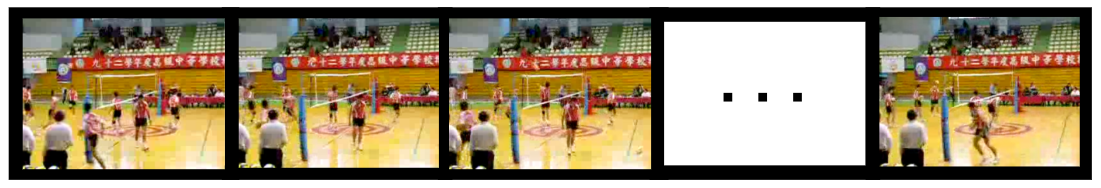



## ¿Trabajar con video?

Un video esta compuesto por una secuencia de frames (imágenes) que fue grabado a cierta frecuencia de muestro (por ejemplo 24 frames por segundo). Implementemos algunas funciones de utilería que nos permitirán cargar un video a memoria (a partir de su path) como una secuencia de frames en formato de imágenes RGB.

In [6]:
# Incluyamos algunos de los módulos que utilizaremos en la primer parte de la actividad
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import os
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import seaborn as sns

In [7]:
# Algunos hiperparámetros que nos conviene definir respecto a las características de los datos
IMG_SIZE = 224
BATCH_SIZE = 5
MAX_SEQ_LENGTH = 8

In [8]:
# Los frame podrían no ser rectangulares,
# Tomemos un recuadro del centro del frame
def crop_csquare(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [9]:
# Implementemos una función que nos permita cargar a memoria un video
# como una secuencia de imágenes
# path:         ruta en donde se encuentra el archivo de video
# max_frames:   si es igual a 0, toma todos los frames del video frames
#               si es mayor a 0, indica el número de frames a tomar del video
# IMG_SIZE, IMG_SIZE  : define que dimensiones de las imagenes

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_csquare(frame)
            frame = cv.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]    # BGR => RGB
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)



Verifiquemos el funcionamiento de nuestras funciones, cargando dos videos y verificando las dimensiones del tensor que genera.

In [10]:
# Descomprimamos el archivo de datos
import zipfile
with zipfile.ZipFile('./UFC-5.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [11]:
path1 = "./UFC-5/Archery/v_Archery_g01_c01.avi"
path2 = "./UFC-5/Archery/v_Archery_g01_c02.avi"
frames_01=load_video(path1)
frames_02=load_video(path2)
print(frames_01.shape, frames_02.shape)

(131, 224, 224, 3) (142, 224, 224, 3)


In [12]:
# Limitemos el número de frames
frames_01=load_video(path1, MAX_SEQ_LENGTH)
frames_02=load_video(path2, MAX_SEQ_LENGTH)
print(frames_01.shape, frames_02.shape)

(8, 224, 224, 3) (8, 224, 224, 3)


## **3. Análisis y diseño de propuesta de solución.**

Como resultado de un análisis inicial al problema planteado y de los datos que se tienen disponibles,tenemos que:

*   El tipo de tarea que se requiere realice el
modelo es clasificación multiclase, en el que las posibles clases son:

> 1. Archery
> 2. Basketball
> 3. Diving
> 4. PlayingCello
> 5. VolleyballSpiking

* El conjunto de datos consta de 32 videos en los cuales el número de frames(imágenes a color) es variable y cada imagen tiene la forma: (224, 224, 3). Debido a que se tienen muy pocos videos, se propone utilizar las siguientes estrategias:

> 1. Utilizar como base de nuestra solución un modelo preentrenado.
> 2. Aplicar la técnica de aumento de datos para tener mayor cantidad de datos disponibles para el entrenamiento.

* El modelo preentrenado que se propone utilizar es EfficientNetV2B0 (weights='imagenet').

* El tipo de tensores de entrada y salida del modelo base propuesto son:
> 1. Input tensor: (examples, MAX_SEQ_LENGTH, 224, 224, 3)
> 2. Output tensor: (examples, 5)

* Acorde a lo anterior, en la siguiente figura se muestra la porpuesta de arqutectura inicial para el modelo base:


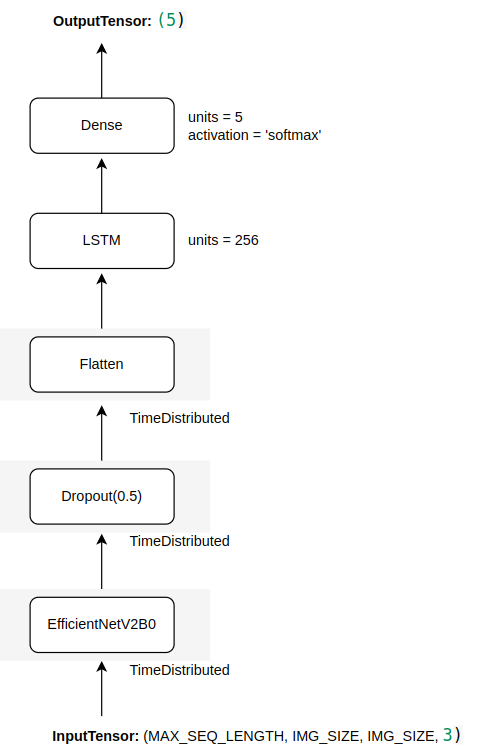

## **4. Implementación de prototipo de solución**

Definamos la carpeta en la cuál tenemos nuestros videos organizados en subcarpetas por clases de acción.

In [13]:
directory = "./UFC-5"

Ahora implementemos una función para poder determinar la clase a la que pertenece cada video, así como obtener la ruta y nombre cada archivo.

In [14]:
def getExamples(directory):
    # encontrar todos los archivos de tipo avi
    X = glob(directory+"/**/*.avi", recursive=True)
    # generar las etiquetas a partir del nombre de la carpeta
    Y = [video.split(os.path.sep)[-2] for video in X]
    #generar la clase en One Hot Vector
    Y = np.array(Y).reshape((-1,1))
    Y = (OneHotEncoder().fit_transform(Y)).toarray()
    return X, Y

In [15]:
video_paths, labels = getExamples(directory=directory)

In [16]:
print(video_paths[0], labels[0])

./UFC-5\Archery\v_Archery_g01_c01.avi [1. 0. 0. 0. 0.]


Como se mostro dentro de los dos primeros videos, estos no poseen las mismas dimensiones temporales, por lo que hay que verificar cuáles son las condiciones en las cuáles se encuentran los videos y determinar cuál podría ser la mejor forma de abordar que estos no tengan la misma dimensionalidad, para ello se buscará a través de todos los datos la primera dimensión (la temporal) de cada uno de los videos

In [17]:
lengths = [load_video(video).shape[0] for video in video_paths]

Y posteriormente gráficarlo para poder verlo más claramente

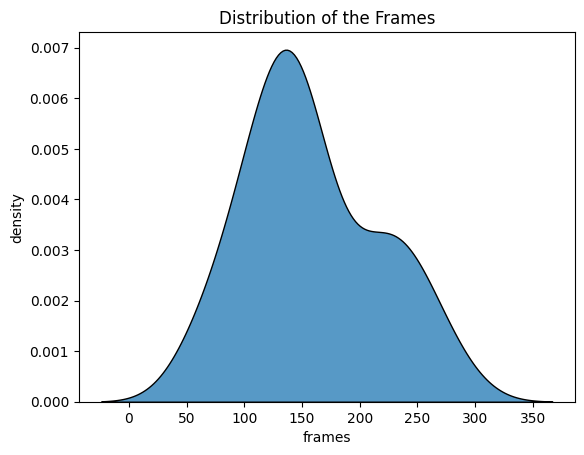

In [18]:
sns.kdeplot(lengths,multiple="stack").set(xlabel='frames', ylabel='density', title='Distribution of the Frames');

In [19]:
def truncate_padd(frames, max_length = MAX_SEQ_LENGTH):
    # padding
    if frames.shape[0] < max_length:
        frames = tf.concat([
            np.zeros((max_length- frames.shape[0],
                      frames.shape[1],
                      frames.shape[2],
                      frames.shape[3])),
            frames], 0)
    #truncated
    else:
        frames = frames[-int(max_length):]
    return frames

In [20]:
def sampling(frames, num_frames=MAX_SEQ_LENGTH):
    #tomar una muestra de frames uniformemente distribuidos a lo largo del video
    # frames[start:end: step),:,:,:]
    sample = frames[::(frames.shape[0]//num_frames),:,:,:]
    #truncar o rellenar en caso de que la muestra no de el número de frames requeridos
    return(truncate_padd(sample, num_frames))

In [21]:
def augmentation(frames):

    #aumento de datos considerando para cada uno de las imagenes
    # se considero que hubiera un flip horizontal sin embargo tensorflow tenía problemas para realizarlo

    # aumentar el brillo de las imagenes
    frames = tf.image.random_brightness(frames, max_delta = 0.5)

    #modificar el contraste de la imagen
    frames = tf.image.random_contrast(frames, lower=0.1, upper=0.7)
    return frames

Visualicemos un frame original y el resultado de las operaciones aplicadas como parte de la técnica de aumento de datos.

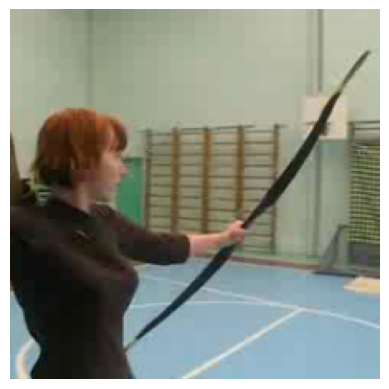

In [22]:
# Imagen original
plt.axis('off')
plt.imshow(frames_01[0]);

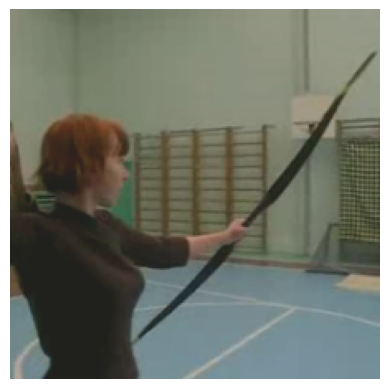

In [23]:
# aumento de datos para un video de frames
prueba = augmentation(truncate_padd(frames_01))

# Imagen aumentada
plt.axis('off')
plt.imshow(prueba[4].numpy().astype(int))

In [24]:
# Generador de datos considerando la carga del video, el muestreo y el aumento de datos

class MySequence(tf.keras.utils.Sequence):
    def __init__(self, x_video, y_class, batch_size):
        self.x_video = x_video
        self.y_class = y_class
        self.batch_size = batch_size

    def __len__(self):
        return len(self.x_video)//self.batch_size

    def __getitem__(self, idx):
        batch_y = self.y_class[idx*self.batch_size : (idx+1)*self.batch_size]
        batch_x = np.zeros((self.batch_size, MAX_SEQ_LENGTH , IMG_SIZE, IMG_SIZE,3 ))
        for i in range(0, self.batch_size):
            batch_x[i] = augmentation(sampling(load_video(self.x_video[idx*self.batch_size + i])))
        return batch_x, batch_y

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
from tensorflow.keras.layers import Input, Dense, TimeDistributed
from tensorflow.keras.layers import Dropout, Flatten, LSTM
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

Para la separación de los datos en fase de entrenamiento y validación se escogió un tamaño que por lo menos fuera de 10% de los datos y que de la misma forma tuviera por lo menos el tamaño de un batch, lel tamaño de batch se consideraron además que fuera divisor del total de datos obtenidos

In [27]:
# Partición de los datos en entrenamiento y validación
X_train,X_test, Y_train,  Y_test = train_test_split(video_paths, labels, test_size = 0.13, shuffle = True, random_state= 3)

In [28]:
# Backbone convolucional para la red
from tensorflow.keras.applications import EfficientNetV2B0

Debido a que la entrada es un video, compuesto por multiples imagenes distribuidas a través del tiempo se propone que la arquitectura se utilice una red convolucional pre entrenada como backbone la cuál va a estar distribuida, a través del tiempo para que se procese cada imagen por separado, posteriormente se hará un dropout como método de regularización y pasará a una un red recurrente LSTM, que tendrá una sola salida que pasa a una capa densa con 5 neuronas y activación softmax para identificar cada una de las clases propuestas.

In [29]:
# Modelo preentrenado (utilizando el API funcional de Keras)
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
eNet = EfficientNetV2B0(weights='imagenet', include_top=False, input_tensor=input_tensor)
eNet.trainable = False

out_tensor = eNet.output
pretrained_model = Model(inputs=input_tensor, outputs=out_tensor)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [36]:
# Construyamos nuestro modelo personalizado
input_tensor = Input(shape=(MAX_SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3))

x_tensor = TimeDistributed(pretrained_model)(input_tensor)
x_tensor = TimeDistributed(Dropout(0.5))(x_tensor)
x_tensor = TimeDistributed(Flatten())(x_tensor)
x_tensor = LSTM(units=25, return_sequences=False)(x_tensor)
output_tensor = Dense(5, activation='softmax')(x_tensor) #Debería llevar más capas antes de esta capa de salida


In [37]:
# Construyamos el modelo y compilemos
model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', 'precision', 'recall'])

# Resumen del modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 8, 224, 224, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 7, 7, 1280)  │     5,919,312 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 8, 7, 7, 1280)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 8, 62720)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 25)             │     6,274,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,194,042 (46.52 MB)

 Trainable params: 6,274,730 (23.94 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [32]:
# Agreguemos dos Callbacks: Checkpoint y EarlyStopping




In [33]:
#Entrenamiento del modelo usando el generador para datos de entrenamiento y validación




In [34]:
def plot_learning_h(history,variables):
    n = len(variables)
    # subgráficas para cada uno de las métricas a gráficar
    fig, axs = plt.subplots(1,n, figsize = (15,4))
    [axs[i].plot(history.history[variables[i]]) for i in range(n)]
    [axs[i].set_title(variables[i]) for i in range(n)]
    [axs[i].set_xlabel('Epochs') for i in range(n)]
    [axs[i].set_ylabel(variables[i][4:]) for i in range(n)]

In [35]:
plot_learning_h(h,['loss','Precision','Accuracy'])

NameError: name 'h' is not defined

In [ ]:
plot_learning_h(h,['val_loss','val_Precision','val_Accuracy'])

¡Escenario base listo para la búsqueda de hiperparámetros a partir de un modelo base en un problema acotado!

* ¿Falta entrenamiento?
* ¿Necesitamos más datos?
* ¿Necesitamos un modelo má complejor?
* ¿Cómo reducimos el Bias y Variance del modelo?



